In [1]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
from sklearn.model_selection import train_test_split

algorithm_globals.random_seed = 12345

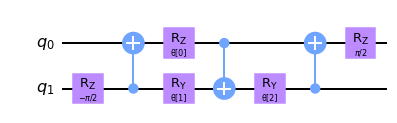

In [2]:

def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target


# Let's draw this circuit and see what it looks like
params = ParameterVector("θ", length=3)
circuit = conv_circuit(params)
circuit.draw("mpl")

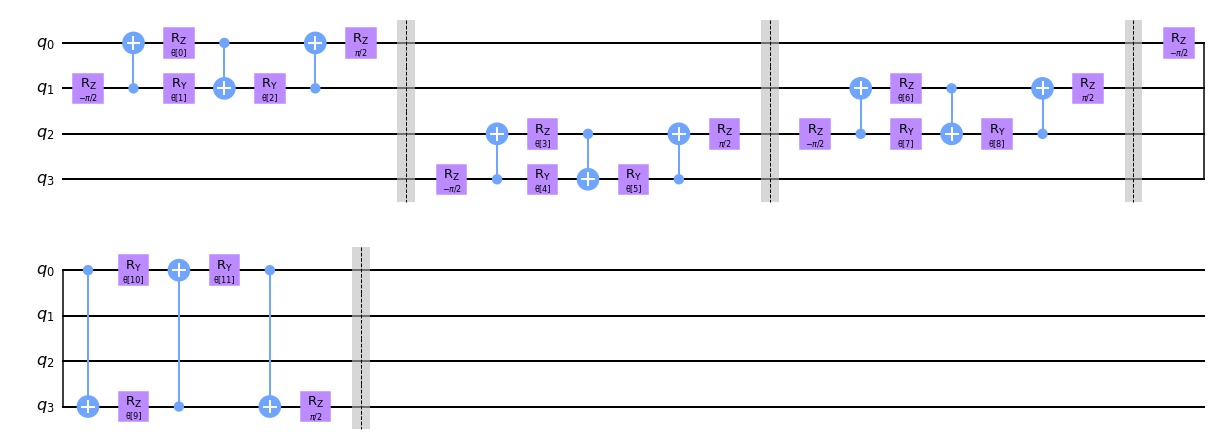

In [3]:
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc


circuit = conv_layer(4, "θ")
circuit.decompose().draw("mpl")

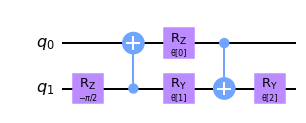

In [4]:
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target


params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)
circuit.draw("mpl")

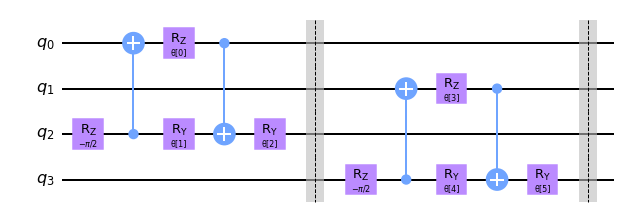

In [5]:
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc


sources = [0, 1]
sinks = [2, 3]
circuit = pool_layer(sources, sinks, "θ")
circuit.decompose().draw("mpl")

In [6]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()

In [7]:
import pandas as pd

In [8]:
df = pd.DataFrame(data=data.data,columns=data.feature_names)
df['target']=data.target

In [9]:
d = df
x = d.drop(['target'],axis=1)
y = d['target']

In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x = pd.DataFrame(scaler.fit_transform(x),columns=x.columns)

In [11]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
x = pca.fit_transform(x)
print(pca.explained_variance_ratio_)

[0.44272026 0.18971182 0.09393163 0.06602135]


In [12]:
from sklearn.preprocessing import MinMaxScaler
x = MinMaxScaler().fit_transform(x)

In [13]:
pip install qiskit

Note: you may need to restart the kernel to use updated packages.


In [14]:
algorithm_globals.random_seed = 123
train_features, test_features, train_labels, test_labels = train_test_split(x,y,train_size=0.8,random_state=algorithm_globals.random_seed)

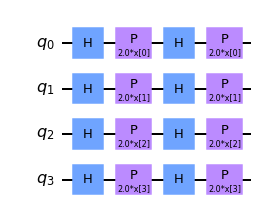

In [15]:
feature_map = ZFeatureMap(4)
feature_map.decompose().draw("mpl")

In [16]:
feature_map = ZFeatureMap(4)

ansatz = QuantumCircuit(4, name="Ansatz")

# First Convolutional Layer
ansatz.compose(conv_layer(4, "с1"), list(range(4)), inplace=True)

# First Pooling Layer
ansatz.compose(pool_layer([0, 1,], [2, 3], "p1"), list(range(4)), inplace=True)

# Second Convolutional Layer
ansatz.compose(conv_layer(2, "c2"), list(range(2, 4)), inplace=True)

# Second Pooling Layer
ansatz.compose(pool_layer([0], [1], "p2"), list(range(2, 4)), inplace=True)

# Combining the feature map and ansatz
circuit = QuantumCircuit(4)
circuit.compose(feature_map, range(4), inplace=True)
circuit.compose(ansatz, range(4), inplace=True)

observable = SparsePauliOp.from_list([("Z" + "I" * 3, 1)])

# we decompose the circuit for the QNN to avoid additional data copying
qnn = EstimatorQNN(
    circuit=circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
)

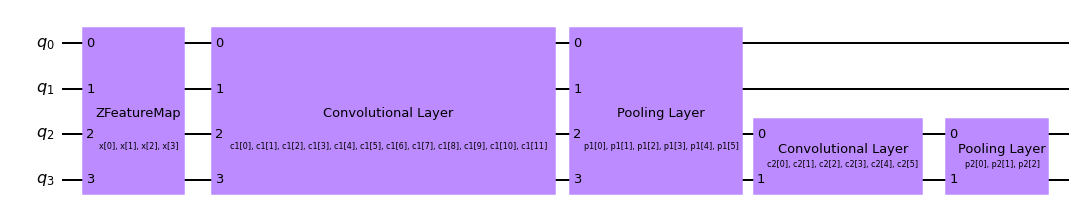

In [17]:
circuit.draw("mpl")


In [18]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [19]:
initial_point = np.random.random(ansatz.num_parameters)
initial_point

array([0.07234546, 0.8608508 , 0.7358386 , 0.15936995, 0.5525258 ,
       0.55448519, 0.4739753 , 0.22070732, 0.26474113, 0.5415258 ,
       0.49903842, 0.59526369, 0.87975444, 0.62551949, 0.74234873,
       0.59195722, 0.27532701, 0.4625943 , 0.90432517, 0.21278909,
       0.20482796, 0.95668529, 0.34406082, 0.88911856, 0.57554446,
       0.98654015, 0.63530186])

In [20]:
classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=100),  # Set max iterations here
    callback=callback_graph,
    initial_point=initial_point,
)

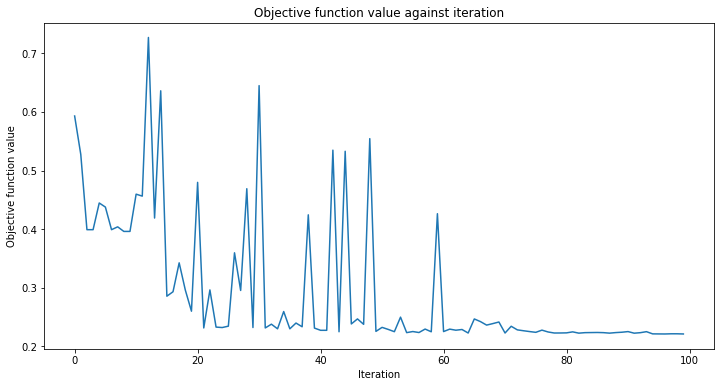

Accuracy from the train data : 62.42%
Time taken: 190.10080099105835 seconds


In [21]:
import time
start = time.time()
x = np.asarray(train_features)
y = np.asarray(train_labels)
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
classifier.fit(x, y)

# score classifier
print(f"Accuracy from the train data : {np.round(100 * classifier.score(x, y), 2)}%")
end = time.time()
time = end-start
print(f"Time taken: {time} seconds")

In [23]:
import time
start = time.time()
y_predict = classifier.predict(test_features)
x = np.asarray(test_features)
y = np.asarray(test_labels)
print(f"Accuracy from the test data : {np.round(100 * classifier.score(x, y), 2)}%")
end = time.time()
time = end-start
print(f"Time taken: {time} seconds")

Accuracy from the test data : 64.04%
Time taken: 0.881486177444458 seconds
